In [12]:
# Install dependencies here
#%pip install ___

In [13]:
# Include your imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
import torch
from skimage.feature import hog
import os 
import pickle 
import random 
from torch.utils import data 

In [14]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

In [15]:
from google.colab import drive
drive.mount('/gdrive')
%cp -r /gdrive/MyDrive/Data/* /content/
%cd /content

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/content


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[5 7 3 5 5 3 3 1 7 3 3 1]


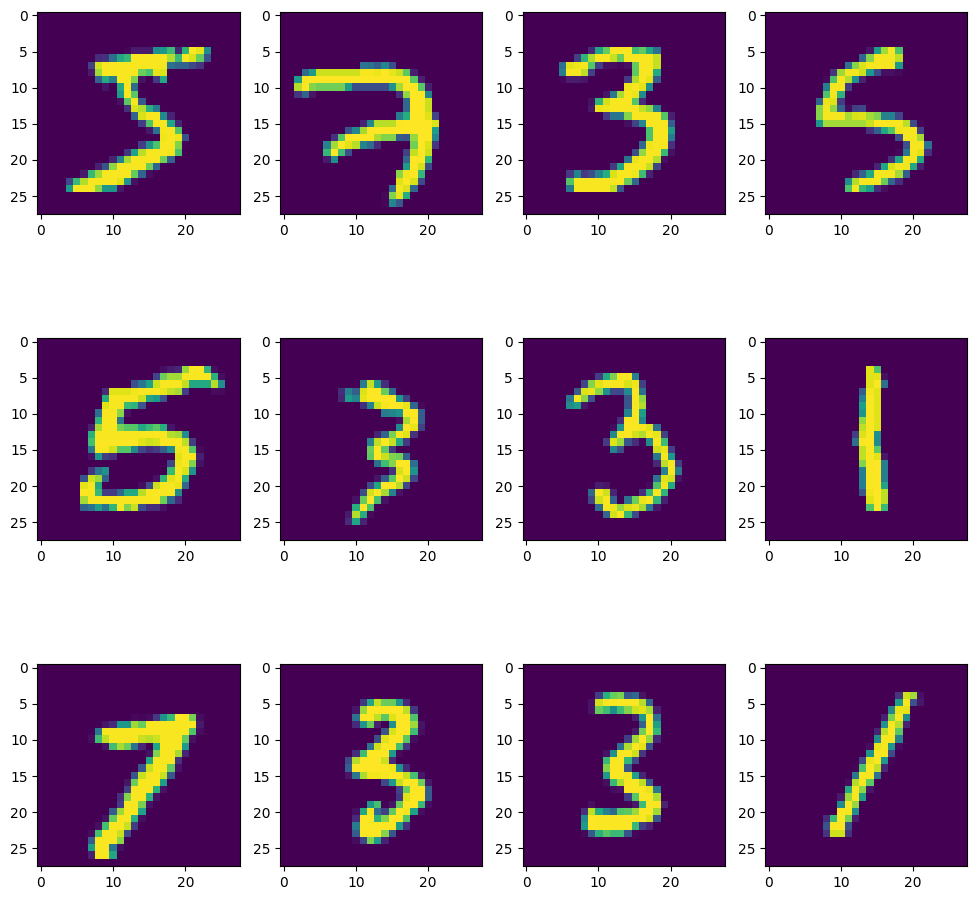

In [16]:
#MODELO RED NEURONAL CONVOLUCIONAL COMPLETO

#PASO 1 - CARGA DE DATOS (Carga de imágenes desde el pickle)
with open('MNIST_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)
with open('MNIST_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)


  #Comprobación del dataset de Train: 60.000 filas y resolución 28x28
print(X_train.shape)
print(y_train.shape)

  #Comprobación del dataset de Test: 10.000 filas y resolución 28x28
print(X_test.shape)
print(y_test.shape)

  #Visualización de imágenes
im = io.imshow_collection(X_train[::5000,:,:]) 
print(y_train[::5000])

In [17]:
# ----------------------------------------------------------------------------

#PASO 2 - PREPARACIÓN DATOS

#2.1 NORMALIZACIÓN (Reescalar imágenes: normalizamos los píxeles de -0,5 a 0,5)
def reescalar_dataset (dataset):
    scaled_dataset = (dataset / 255.0) - 0.5
    return scaled_dataset

X_train_n = reescalar_dataset(X_train)
X_test_n = reescalar_dataset(X_test)

  #Comprobación del reescalado
print((np.min(X_train), np.max(X_train)))
print((np.min(X_train_n), np.max(X_train_n)))


#2.2 CONVERTIR VARIABLES A TENSORES PYTORCH
tX_train = torch.tensor(X_train_n, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test_n, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long)


#2.3 AJUSTAR DIMENSIONES (Agregar dimensión de canales)
tX_train_c = tX_train.unsqueeze(1)
tX_test_c = tX_test.unsqueeze(1)
ty_train_c = ty_train
ty_test_c = ty_test

  #Comprobación canales
print(tX_train.shape)
print(tX_train_c.shape)



(0, 255)
(-0.5, 0.5)
torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


In [18]:
# ----------------------------------------------------------------------------

#PASO 3 - CREACIÓN RED NEURONAL CONVOLUCIONAL

#3.1 DEFINICIÓN ESTRUCTURA DE RED
  #Definición clase Flatten
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

  #Creación de la estructura de red 
nn2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), # in_channels, out_channels
    torch.nn.MaxPool2d(2), #kernel_size
    torch.nn.LeakyReLU(),

    torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(2),
    torch.nn.LeakyReLU(),

    Flatten(),
    torch.nn.Linear(32*7*7, 10), 
    torch.nn.LogSoftmax(dim=1) 
)

  #'Forward Pass' de un módulo
nn2(tX_train_c)


  #Comprobación de parámetros
print("\nNº parametros total:", np.sum([np.prod(p.shape) for p in nn2.parameters()]))


#Mover tensores y modulos a la GPU
nn2 = nn2.cuda()
tX_train_c = tX_train_c.cuda()
tX_test_c = tX_test_c.cuda()
ty_train_c = ty_train_c.cuda()
ty_test_c = ty_test_c.cuda()


#3.2 ENTRENAMIENTO DE LA RED

  #Semilla
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)

do_seeds(29)


  #Inicialización "Xavier" (inicializa los parámetros con una distribución distinta en cada capa en vez de con valores aleatorios uniformes)
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

init_f(nn2)


  #Función de loss - NLLLoss (negative log likelihood loss)
def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y)


  #Función de paso
def t_step(x, y, forw, opt):
    opt.zero_grad() # reseteamos los valores acumulados de las derivadas
    loss = loss_f(x, y, forw) # calculamos la 'loss' con los resultados 
    out = loss.item() # almacenamos nuestro valor de loss para devolverlo como resultado intermedio
    loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
    opt.step() # ejecutamos un paso de nuestro optimizador
    return out


  #Optimizador ADAM
opt2 = torch.optim.Adam(nn2.parameters(), weight_decay=0.008, lr=0.0002)


  #Implementación de mini-batches - Ojo a las dimensiones de los datos de entrada!!
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train_c, ty_train_c), 
                                       batch_size=500, shuffle=True) # shuffle: reordena el dataset en cada epoch

  #Entrenamiento
for i in range(500): #Entrenamos 300 epochs
    for x_j, y_j in mini_b:
        out = t_step(x_j, y_j, nn2, opt2) 
    if i%50 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))
   




Nº parametros total: 28938
Epoch: 0, Loss: 0.7296
Epoch: 50, Loss: 0.0520
Epoch: 100, Loss: 0.0785
Epoch: 150, Loss: 0.0703
Epoch: 200, Loss: 0.0602
Epoch: 250, Loss: 0.0682
Epoch: 300, Loss: 0.0717
Epoch: 350, Loss: 0.0504
Epoch: 400, Loss: 0.0694
Epoch: 450, Loss: 0.0690


In [19]:
# ----------------------------------------------------------------------------

#PASO 4 - RESULTADOS

#Función de predicción
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

#Función de scoring
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

#Resultados de la red neuronal entrenada
print(score_f(tX_train_c, ty_train_c, nn2))
print(score_f(tX_test_c, ty_test_c, nn2))


#Ejemplo entrenado
print(ty_train_c[0:5]) # etiquetas reales de las 5 primeras imágenes
pd.DataFrame(torch.exp(nn2(tX_train_c[0:5, :])).cpu().detach().numpy()) # probabilidades 5 primeras imágenes


#Estadísticas del training
tr_stats2 = np.stack([np.array([i,
                                np.mean(list(t_step(x_j, y_j, nn2, opt2) for x_j, y_j in mini_b)),
                                loss_f(tX_train_c, ty_train_c, nn2).item(),
                                loss_f(tX_test_c, ty_test_c, nn2).item(),
                                score_f(tX_train_c, ty_train_c, nn2),
                                score_f(tX_test_c, ty_test_c, nn2)]) for i in range(500)], axis=0)
tr_stats2_df = pd.DataFrame(tr_stats2, columns=['epoch', 'mean_loss', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])


0.9848333333333333
0.9845
tensor([5, 0, 4, 1, 9], device='cuda:0')


[None]

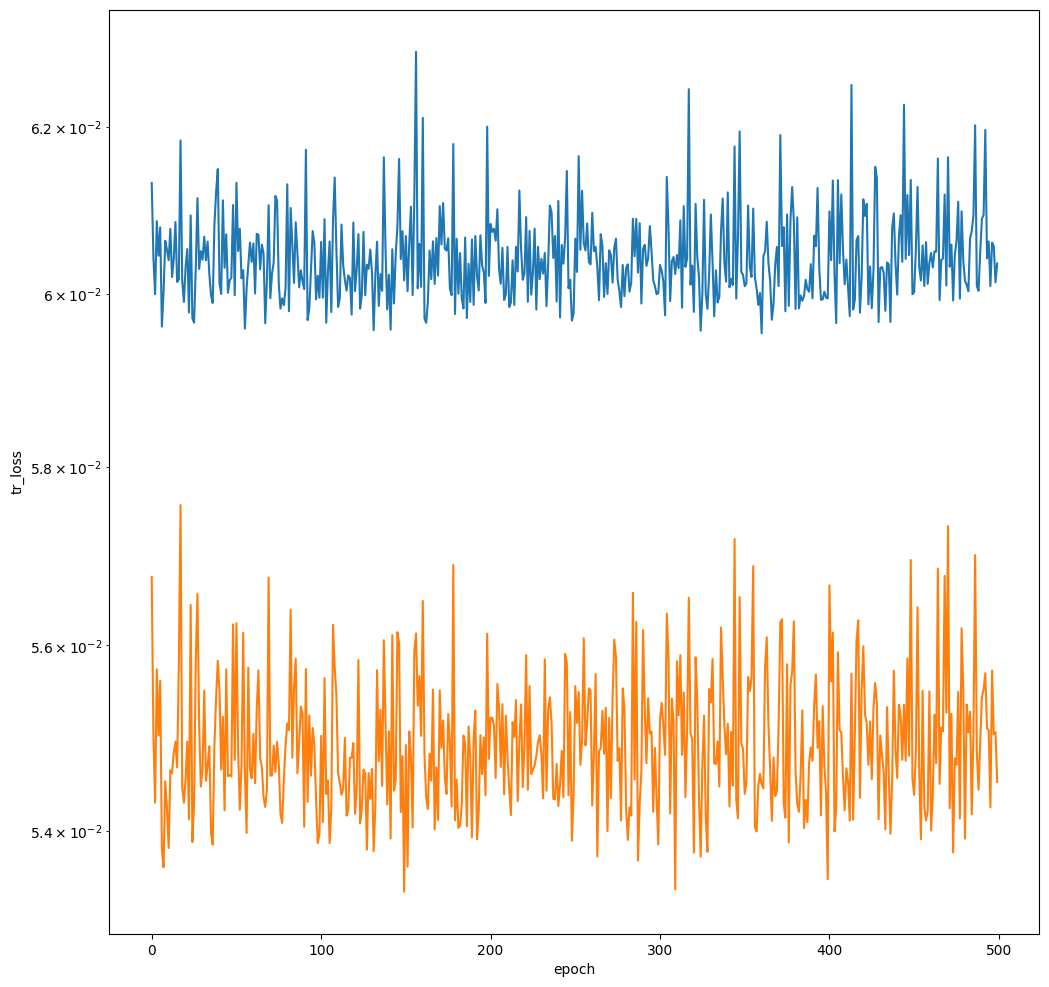

In [20]:
#Visualización del loss para el training y el testing
ax = sns.lineplot(x='epoch', y='tr_loss', data=tr_stats2_df)
sns.lineplot(x='epoch', y='te_loss', data=tr_stats2_df, ax=ax)
ax.set(yscale="log")


<Axes: xlabel='epoch', ylabel='tr_score'>

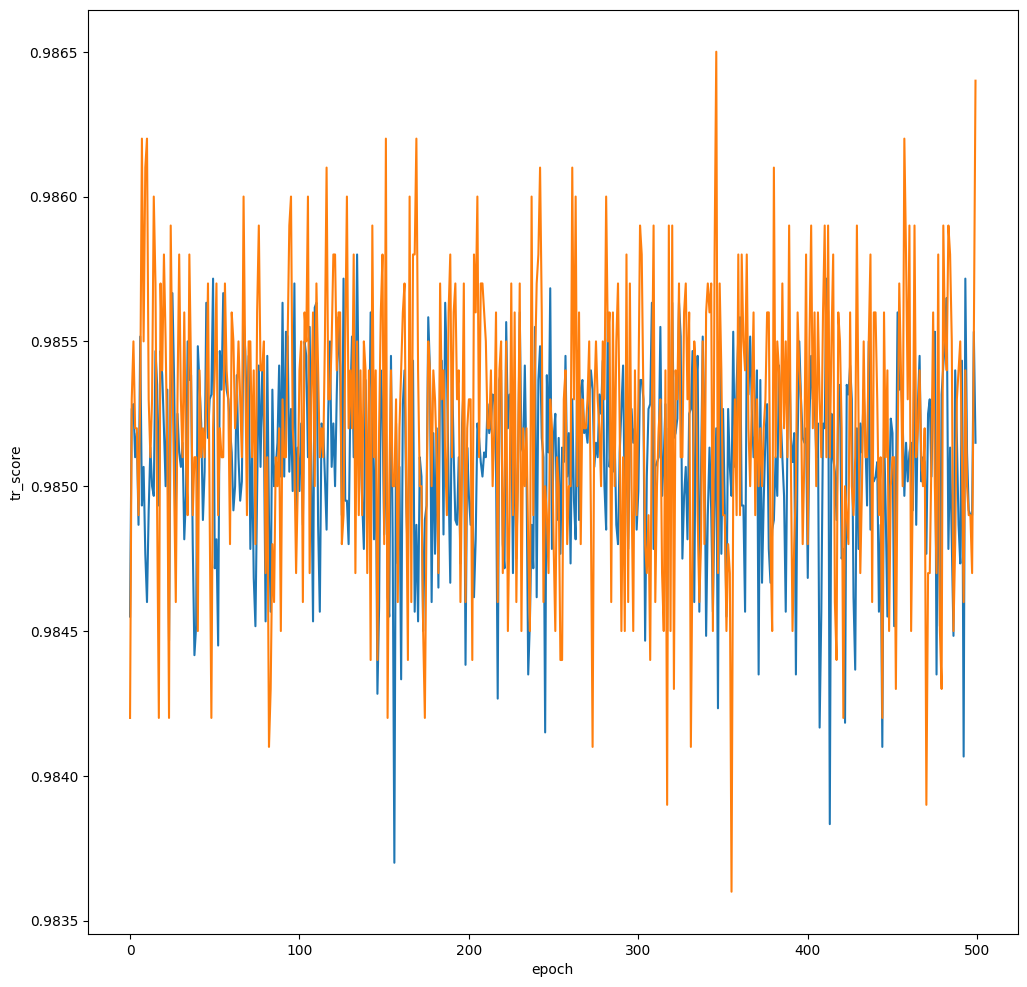

In [21]:
#Visualización de la puntuación para el training y el testing
sns.lineplot(x='epoch', y='tr_score', data=tr_stats2_df)
sns.lineplot(x='epoch', y='te_score', data=tr_stats2_df)